In [1]:
import pandas as pd

# File path to your dataset
file_path = '/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv'

# Load the dataset into a Pandas DataFrame
weather_data = pd.read_csv(file_path)

# Display the first few rows
weather_data.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [2]:
weather_data.shape

(145460, 23)

In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
weather_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
weather_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

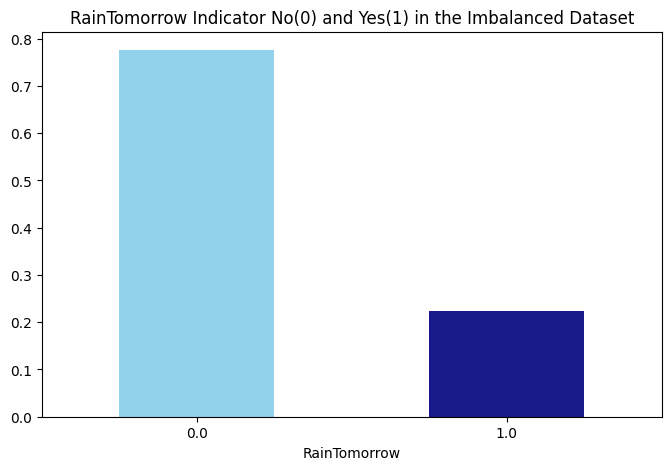

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
weather_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

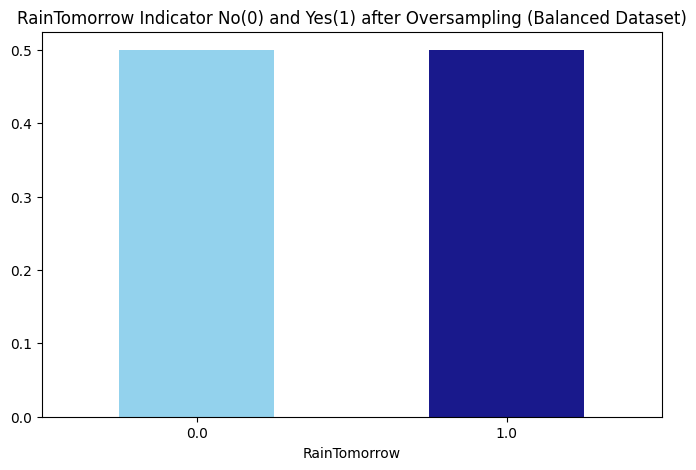

In [6]:
from sklearn.utils import resample

no = weather_data[weather_data.RainTomorrow == 0]
yes = weather_data[weather_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [7]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [8]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [9]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [10]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [13]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [14]:
# Removing outliers from dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

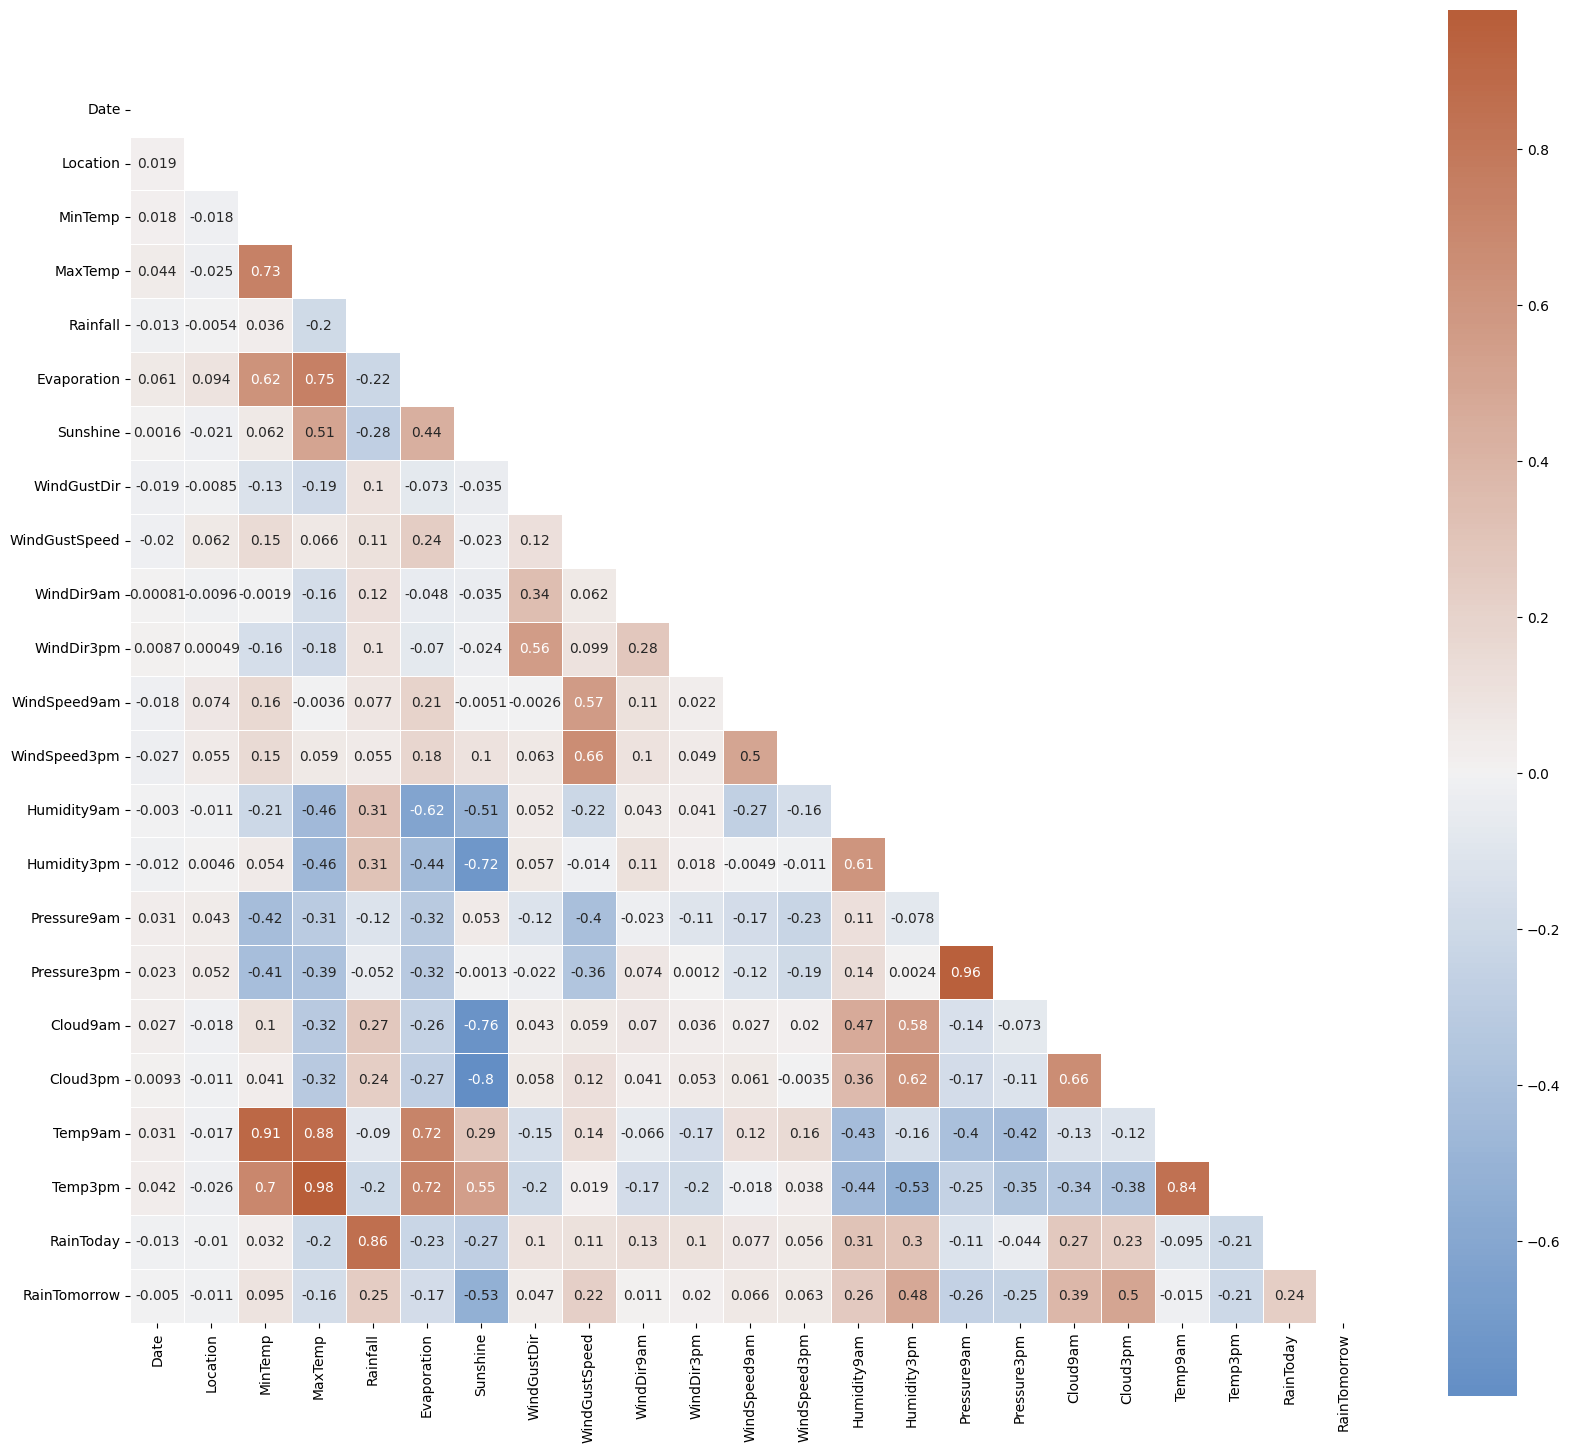

In [15]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = MiceImputed.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))  # Changed np.bool to bool

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Create a custom diverging colormap
cmap = sns.diverging_palette(250, 25, as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=None, center=0,
    square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9}
)

plt.show()

In [16]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)
modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,...,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,...,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,...,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,...,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,...,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


In [17]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


In [19]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [20]:
# Check for duplicate rows
duplicates = MiceImputed.duplicated()

# Print the duplicate rows (if any)
print(MiceImputed[duplicates])

# Remove duplicates and reset index
MiceImputed = MiceImputed.drop_duplicates().reset_index(drop=True)

        Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
80931   3369        44     13.4     25.8       0.0     7.400000  5.100000   
44112   1961        47     11.4     17.1       0.0     2.278123  6.164560   
50483   1857        40     15.5     30.3       0.0     6.957122  8.858200   
58352    606         6      4.7     15.1       0.6     1.200000  6.092573   
872     1268         2      5.8     22.0       0.0     1.339046  4.836741   
...      ...       ...      ...      ...       ...          ...       ...   
76265   1712        33      9.1     14.9       3.0     4.000000  7.400000   
140102  1234        13     25.7     28.3       0.8     3.000000  0.000000   
134889  2254        17     13.6     26.3       0.0     4.154078  5.671084   
129024  2622        43     12.1     22.6       0.0     3.581046  6.142643   
87307    503         8     24.8     31.5       0.0     5.400000  3.400000   

        WindGustDir  WindGustSpeed  WindDir9am  ...  Humidity9am  Humidity3

In [21]:
# Fix negative values in numerical columns
numerical_columns = ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
for col in numerical_columns:
    MiceImputed[col] = MiceImputed[col].apply(lambda x: max(x, 0))  # Replace negative values with 0

# Fix `RainToday` column to ensure it only contains 0 or 1
MiceImputed['RainToday'] = MiceImputed['RainToday'].apply(lambda x: 1 if x >= 0.5 else 0)

# (Optional) Save the cleaned dataset
MiceImputed.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'.")


Cleaned dataset saved as 'cleaned_dataset.csv'.


In [22]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Accuracy = 0.7952798350051561
ROC Area under Curve = 0.7895421146723749
Cohen's Kappa = 0.5823246558119864
Time taken = 3.2661960124969482
              precision    recall  f1-score   support

         0.0    0.80459   0.83764   0.82078     23879
         1.0    0.78229   0.74144   0.76132     18789

    accuracy                        0.79528     42668
   macro avg    0.79344   0.78954   0.79105     42668
weighted avg    0.79477   0.79528   0.79460     42668



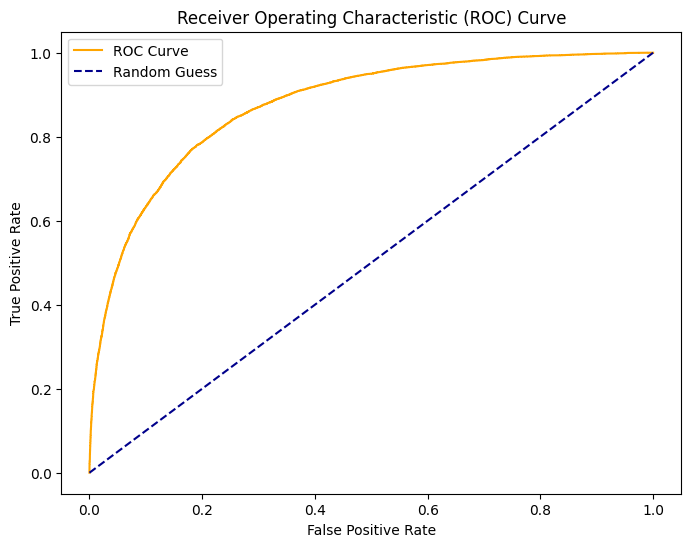

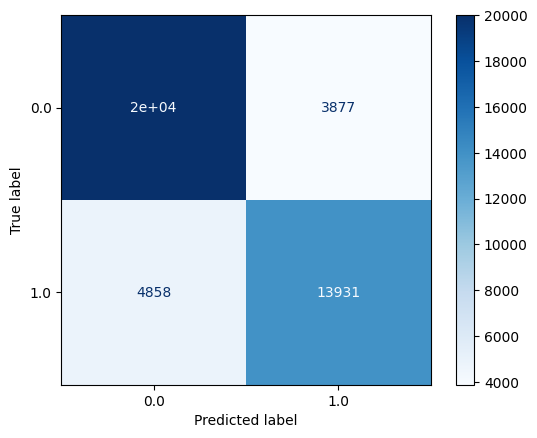

Model saved to LogisticRegression_model.pkl
Accuracy = 0.9333458329427206
ROC Area under Curve = 0.9378631464101468
Cohen's Kappa = 0.866233152337708
Time taken = 9.737097024917603
              precision    recall  f1-score   support

         0.0    0.97922   0.90000   0.93794     23879
         1.0    0.88475   0.97573   0.92802     18789

    accuracy                        0.93335     42668
   macro avg    0.93199   0.93786   0.93298     42668
weighted avg    0.93762   0.93335   0.93357     42668



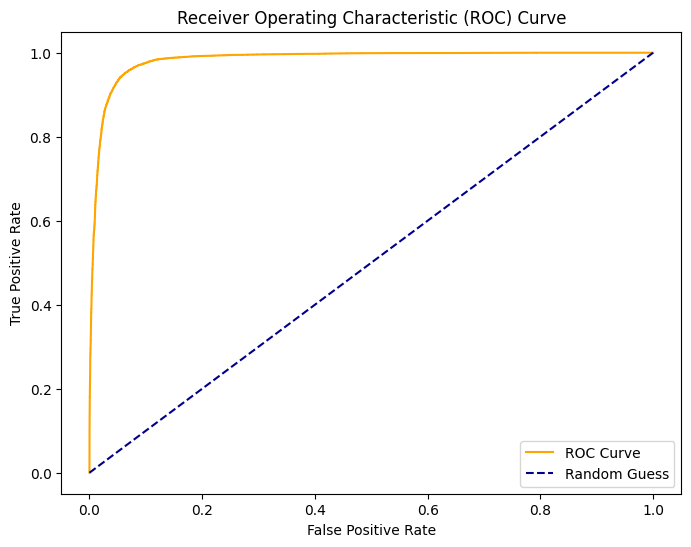

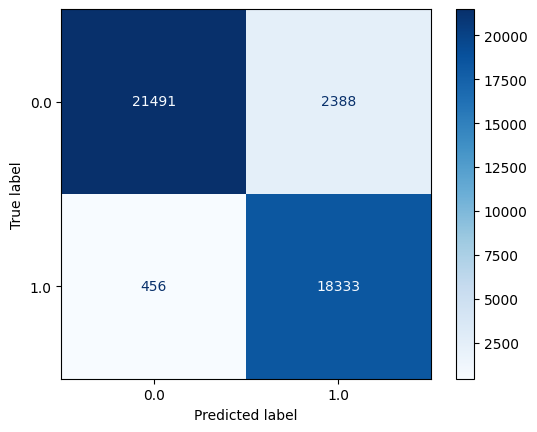

Model saved to XGBoost_model.pkl
Accuracy = 0.9269944689228462
ROC Area under Curve = 0.9282690657758537
Cohen's Kappa = 0.8525676790377509
Time taken = 25.498719692230225
              precision    recall  f1-score   support

         0.0    0.95026   0.91758   0.93363     23879
         1.0    0.89964   0.93895   0.91888     18789

    accuracy                        0.92699     42668
   macro avg    0.92495   0.92827   0.92626     42668
weighted avg    0.92797   0.92699   0.92714     42668



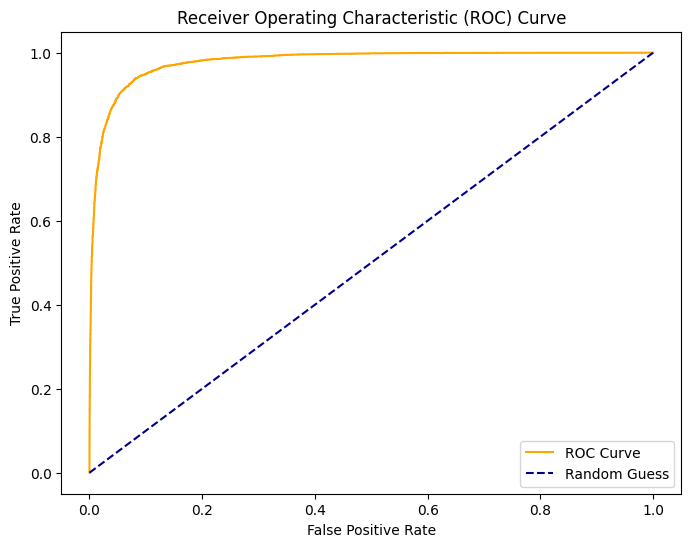

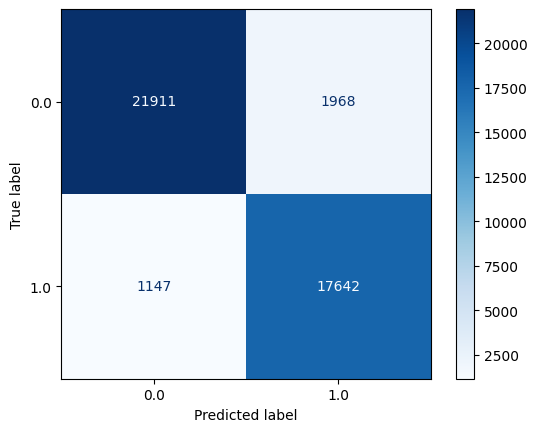

Model saved to RandomForest_model.pkl


In [23]:
import joblib
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, classification_report, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

def plot_roc_cur(fper, tper):
    """Function to plot the ROC curve."""
    plt.figure(figsize=(8, 6))
    plt.plot(fper, tper, color='orange', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def run_model(model, X_train, y_train, X_test, y_test, model_name, verbose=True):
    t0 = time.time()

    # Train the model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
   coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0

    print(f"Accuracy = {accuracy}")
    print(f"ROC Area under Curve = {roc_auc}")
    print(f"Cohen's Kappa = {coh_kap}")
    print(f"Time taken = {time_taken}")
    print(classification_report(y_test, y_pred, digits=5))

    # Get probabilities for ROC curve
    probs = model.predict_proba(X_test)
    fper, tper, thresholds = roc_curve(y_test, probs[:, 1])
    plot_roc_cur(fper, tper)  # Plot the ROC curve

    # Display confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

    # Save the model to a file using joblib
    model_filename = f"{model_name}_model.pkl"  # Create a filename based on the model's class name
    joblib.dump(model, model_filename)
    print(f"Model saved to {model_filename}")

    return model, accuracy, roc_auc, coh_kap, time_taken

# Logistic Regression Model
params_lr = {'penalty': 'l1', 'solver': 'liblinear'}
model_lr = LogisticRegression(**params_lr)

# Run the Logistic Regression model and save it
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test, 'LogisticRegression')

# XGBoost Model
params_xgb = {'n_estimators': 500, 'max_depth': 16}
model_xgb = xgb.XGBClassifier(**params_xgb)

# Run the XGBoost model and save it
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test, 'XGBoost')

# Random Forest Model
params_rf = {'n_estimators': 100, 'max_depth': 16, 'random_state': 42}
model_rf = RandomForestClassifier(**params_rf)

# Run the Random Forest model and save it
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test, 'RandomForest')


In [24]:
model_lr_loaded = joblib.load('LogisticRegression_model.pkl')
model_xgb_loaded = joblib.load('XGBoost_model.pkl')
model_rf_loaded = joblib.load('RandomForest_model.pkl')


In [25]:
# Make predictions using the loaded models
y_pred_lr = model_lr_loaded.predict(X_test)
y_pred_xgb = model_xgb_loaded.predict(X_test)
y_pred_rf = model_rf_loaded.predict(X_test)

# Print or process the predictions as needed
print(f"Logistic Regression Predictions: {y_pred_lr}")
print(f"XGBoost Predictions: {y_pred_xgb}")
print(f"Random Forest Predictions: {y_pred_rf}")

Logistic Regression Predictions: [0. 0. 0. ... 0. 0. 0.]
XGBoost Predictions: [1 0 0 ... 0 0 1]
Random Forest Predictions: [0. 0. 0. ... 0. 0. 1.]


In [26]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.9 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Corrected paths to where the model files are stored
model_lr_loaded = joblib.load('/kaggle/working/LogisticRegression_model.pkl')
model_rf_loaded = joblib.load('/kaggle/working/RandomForest_model.pkl')
model_xgb_loaded = joblib.load('/kaggle/working/XGBoost_model.pkl')


In [28]:
!pip install joblib


In [29]:
feature_names = features  # List of feature names
joblib.dump(feature_names, 'feature_names.pkl')


['feature_names.pkl']